In [1]:
import sys
sys.path.append('..')
sys.path.append('../../src/')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from os import path
from glob import glob

import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, GlobalAvgPool2D
from keras.layers import Dense, Dropout, Concatenate
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence

from sklearn.model_selection import train_test_split

from utils import load, plot
from local_config import FOLDER_IMAGES, FOLDER_MODELS
from global_config import RANDOM_SEED, IMAGE_SIZE
from custom_metrics import precision, recall, f1, specificity 
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import equal_error_rate as eer

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
FILE_BASE_MODEL = '../../models/siamese_networks/model_2020_05_23-16_43_01.h5'
FOLDER_POS = "positives"
FOLDER_NEG = "negatives"

TEST_SIZE = 0.2
ALPHA = 2.0
MLFLOW_EXPERIMENT_NAME = 'Siamese Networks'

print(FILE_BASE_MODEL)
print(FOLDER_IMAGES)
print(FOLDER_MODELS)

../../models/siamese_networks/model_2020_05_23-16_43_01.h5
../../data/siamese_networks
../../models/siamese_networks


In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Triplet Generator 

In [4]:
class RandomTripletGenerator(Sequence):
    """Generate Random Triplets (A, P, N) for Siamese Networks on the fly"""
    def __init__(self, pos_files, neg_files, image_size, emb_dim, batch_size=1, datagen=ImageDataGenerator()):
        self.pos_files = pos_files
        self.neg_files = neg_files
        self.emb_dim = emb_dim
        self.image_size = image_size
        self.batch_size = batch_size
        self.datagen = datagen
        
    def __len__(self):
        n_pos = len(self.pos_files)
        n_neg = len(self.neg_files)
        return min(n_pos, n_neg) // self.batch_size
    
    def __getitem__(self, idx):
        random_pos = np.random.choice(self.pos_files, size=self.batch_size, replace=False)
        random_neg = np.random.choice(self.neg_files, size=self.batch_size, replace=False)
        
        anchor_set = set(self.neg_files).difference(random_neg)
        random_anc = np.random.choice(list(anchor_set), size=self.batch_size, replace=False)
        
        anc_batch = load.images_from_list_files(random_anc, self.image_size, interpolation=cv2.INTER_AREA, show_progress=False)
        pos_batch = load.images_from_list_files(random_pos, self.image_size, interpolation=cv2.INTER_AREA, show_progress=False)
        neg_batch = load.images_from_list_files(random_neg, self.image_size, interpolation=cv2.INTER_AREA, show_progress=False)
        
        anc_batch = self.datagen.flow(anc_batch).next()
        pos_batch = self.datagen.flow(pos_batch).next()
        neg_batch = self.datagen.flow(neg_batch).next()
        
        x = [anc_batch, neg_batch, pos_batch]
        y = np.zeros(shape=(self.batch_size, 3 * self.emb_dim))
        
        return x, y

# Triplet Loss 

In [5]:
def triplet_loss(alpha=0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
        anc -- the encodings for the anchor data
        pos -- the encodings for the positive data
        neg -- the encodings for the negative data
    Returns:
    loss -- real number, value of the loss
    """
    def loss_func(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]

        anc = y_pred[:, 0:int(total_length * 1/3)]
        pos = y_pred[:, int(total_length * 1/3):int(total_length * 2/3)]
        neg = y_pred[:, int(total_length * 2/3):int(total_length * 3/3)]
        
        pos_dist = K.sum(K.square(anc - pos), axis=1)
        neg_dist = K.sum(K.square(anc - neg), axis=1)

        loss = K.maximum(pos_dist - neg_dist + alpha, 0.0)
        return loss
 
    return loss_func

# Load Base Model 

In [6]:
model = load_model(FILE_BASE_MODEL)

encoder = Model(inputs=model.inputs, outputs=model.get_layer(name='encoded').output)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (Batch

# Requirements

In [7]:
def build_requirements_model(base_model, name):
    set_random_seeds()
    
    req_emb = GlobalAvgPool2D()(base_model.output)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='relu', name=f'{name}_dense_1')(req_emb)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='relu', name=f'{name}_dense_2')(req_emb)
    req_emb = Dropout(rate=0.5)(req_emb)
    req_emb = Dense(units=128, activation='tanh', name=f'{name}_embeddings')(req_emb)
    req_model = Model(inputs=base_model.inputs, outputs=req_emb)

    for layer in req_model.layers:
        layer.trainable = (name in layer.name)

    return req_model


def build_siamese_model(req_model):
    set_random_seeds()

    input_anc = Input(shape=(*IMAGE_SIZE, 3))
    input_pos = Input(shape=(*IMAGE_SIZE, 3))
    input_neg = Input(shape=(*IMAGE_SIZE, 3))

    output_anc = req_model(input_anc)
    output_pos = req_model(input_pos)
    output_neg = req_model(input_neg)

    inputs = [input_anc, input_pos, input_neg]
    outputs = Concatenate(axis=-1)([output_anc, output_pos, output_neg])

    triplet_model = Model(inputs, outputs)
    triplet_model.compile(optimizer='adam', loss=triplet_loss(alpha=ALPHA))

    return triplet_model


def train_embeddings(model, train_gen, valid_gen, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    
    list_callbacks = [
        EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True),
    ]
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("alpha", ALPHA)
    mlflow.set_tag("requirement", name)
    mlflow.keras.autolog()

    hist = model.fit_generator(
        train_gen, 
        steps_per_epoch=1000, # trocar pra 1000
        epochs=100, # trocar pra 100
        validation_data=valid_gen,
        validation_steps=100, # trocar pra 1000
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_embeddings(base_model, pos_files, neg_files, datagen, name):
    pos_train, pos_valid = train_test_split(pos_files, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    neg_train, neg_valid = train_test_split(neg_files, test_size=TEST_SIZE, random_state=RANDOM_SEED)

    req_model = build_requirements_model(encoder, name)    
    triplet_model = build_siamese_model(req_model)
    
    emb_dim = triplet_model.output_shape[-1] // 3
    no_datagen = ImageDataGenerator(rescale=1 / 255)
    train_gen = RandomTripletGenerator(pos_train, neg_train, IMAGE_SIZE, emb_dim, datagen=datagen)
    valid_gen = RandomTripletGenerator(pos_valid, neg_valid, IMAGE_SIZE, emb_dim, datagen=no_datagen)
    
    hist, file_model = train_embeddings(triplet_model, train_gen, valid_gen, name)
    plot.keras_hist(hist.history)

    req_model.save(file_model)
    return file_model

#### 2. Blurred

900
846


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Epoch 1/100
1000/1000 [==============================] - 213s 213ms/step - loss: 1.9751 - val_loss: 1.1865
Epoch 2/100
1000/1000 [==============================] - 213s 213ms/step - loss: 1.7302 - val_loss: 1.1815
Epoch 3/100
1000/1000 [==============================] - 212s 212ms/step - loss: 1.5209 - val_loss: 1.5016
Epoch 4/100
1000/1000 [==============================] - 213s 213ms/step - loss: 1.4835 - val_loss: 1.7039
Epoch 5/100
1000/1000 [==============================] - 209s 209ms/step - loss: 1.3513 - val_loss: 2.0372
Epoch 6/100
1000/1000 [==============================] - 214s 214ms/step - loss: 1.3920 - val_loss: 0.4271
Epoch 7/100
1000/1000 [==============================] - 216s 216ms/step - loss: 1.3080 - val_loss: 1.9345
Epoch 8/100
1000/1000 [==============================] - 218s 218ms/step - loss: 1.3052 - val_loss: 1.7453
Epoch 9/100
1000/1000 [==============================] - 212s 212ms/step - loss: 1.2920 - val_loss: 2.0623
Epoch 10/100
1000/1000 [=============

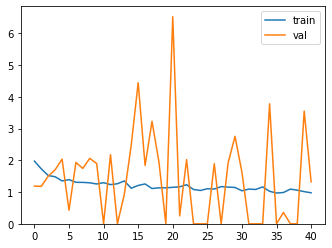

In [8]:
REQ_NAME = 'hat_cap'

pos_files = glob(f"{FOLDER_IMAGES}/{REQ_NAME}/{FOLDER_POS}/*")
neg_files = glob(f"{FOLDER_IMAGES}/{REQ_NAME}/{FOLDER_NEG}/*")
print(len(pos_files))
print(len(neg_files))


datagen = ImageDataGenerator(rescale=1 / 255)

model_file = train_requirement_embeddings(encoder, pos_files, neg_files, datagen, REQ_NAME)

In [16]:
emb_model = load_model(model_file)
emb_model.summary()

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


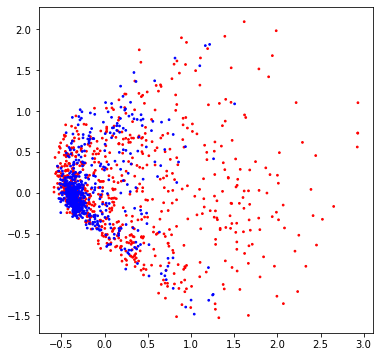

In [31]:
from sklearn.decomposition import PCA

x_pos = load.images_from_list_files(pos_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
x_neg = load.images_from_list_files(neg_files, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

y_pos = np.array([1] * x_pos.shape[0])
y_neg = np.array([0] * x_neg.shape[0])

x = np.concatenate((x_pos, x_neg), axis=0)
y = np.concatenate((y_pos, y_neg))

embeddings = emb_model.predict(x / 255)

emb_2d = PCA(n_components=2).fit_transform(embeddings)

plt.figure(figsize=(6, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=y, s=3, cmap='bwr')

In [32]:
pos_train, pos_valid = train_test_split(pos_files, test_size=TEST_SIZE, random_state=RANDOM_SEED)
neg_train, neg_valid = train_test_split(neg_files, test_size=TEST_SIZE, random_state=RANDOM_SEED)

no_datagen = ImageDataGenerator(rescale=1 / 255)
train_gen = RandomTripletGenerator(pos_train, neg_train, IMAGE_SIZE, 128, datagen=datagen)
valid_gen = RandomTripletGenerator(pos_valid, neg_valid, IMAGE_SIZE, 128, datagen=no_datagen)

req_model = load_model(model_file)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


0.13262933
0.3004208


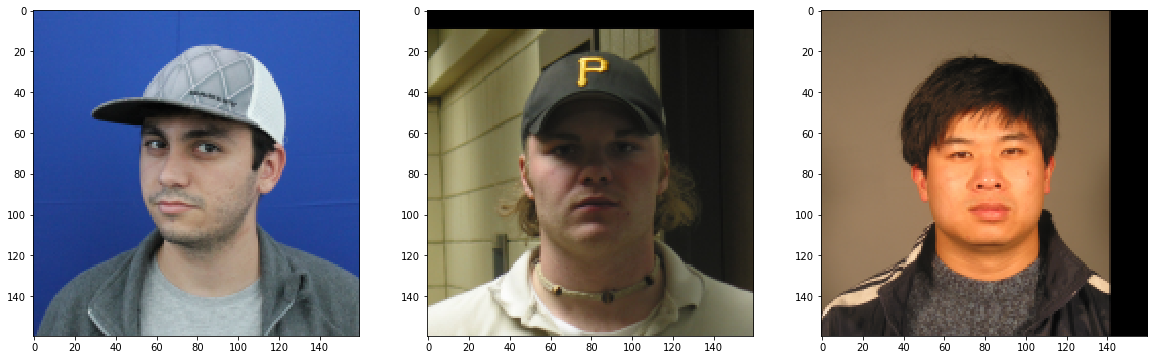

In [33]:
(anc, pos, neg), _ = valid_gen.__getitem__(None)

emb_anc = req_model.predict(anc)
emb_pos = req_model.predict(pos)
emb_neg = req_model.predict(neg)

pos_dist = np.sum((emb_anc - emb_pos) ** 2)
neg_dist = np.sum((emb_anc - emb_neg) ** 2)
loss = np.maximum(0.0, pos_dist - neg_dist + 0.2)

print(pos_dist)
print(neg_dist)

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.imshow((anc.squeeze()*255).astype(np.uint8)[:, :, ::-1])

plt.subplot(1, 3, 2)
plt.imshow((pos.squeeze()*255).astype(np.uint8)[:, :, ::-1])

plt.subplot(1, 3, 3)
plt.imshow((neg.squeeze()*255).astype(np.uint8)[:, :, ::-1])